In [123]:
import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger, DataStructs

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
)

In [124]:
import pandas as pd

# Глобальный список для хранения всех результатов
all_results = []


def log_result(method_name, model_type, n_features, metrics, params=None, stage=None):
    """
    Сохраняет результаты в глобальную таблицу all_results.

    method_name — SHAP / MI / KBest / Lasso
    model_type — RF / OptunaRF / ExtraTrees / GBoost
    n_features — количество используемых фичей
    metrics — словарь метрик {"Accuracy":..., "F1":..., ...}
    params — словарь параметров модели
    stage — этап: baseline / final / optuna / simple_tuning
    """

    record = {
        "Method": method_name,
        "Model": model_type,
        "Stage": stage,
        "Top_Features": n_features,

        # Метрики
        "Accuracy": metrics.get("Accuracy"),
        "Precision": metrics.get("Precision"),
        "Recall": metrics.get("Recall"),
        "F1": metrics.get("F1"),
        "ROC_AUC": metrics.get("AUC"),
    }

    # Добавляем параметры модели, если есть
    if params is not None:
        for key, value in params.items():
            record[f"Param_{key}"] = value

    all_results.append(record)


def save_results_table(filename="all_results.xlsx"):
    """
    Преобразует global all_results → DataFrame и сохраняет таблицу.
    """
    df = pd.DataFrame(all_results)
    df.to_excel(filename, index=False)
    print(f"Saved full results table to {filename}")
    return df


In [125]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)

def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors

def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits

def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

def calculate_maccs_fingerprint(mol):
    feats = {}
    if mol is None:
        return feats

    fp = MACCSkeys.GenMACCSKeys(mol)  # <-- MACCS fingerprint (167 bits)

    arr = np.zeros((fp.GetNumBits(),), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)

    for i, v in enumerate(arr):
        feats[f"MACCS_{i}"] = int(v)

    return feats


Tento kód zabezpečuje dve hlavné úlohy pri spracovaní chemických štruktúr.
Prvá funkcia molecule_from_smiles načíta molekulu zo SMILES reťazca, odstráni soli a znovu ju sanitizuje, aby bola chemicky konzistentná a vhodná na výpočty. Zároveň potláča RDKit logy, aby výstup nebol zahltený internými varovaniami.
Druhá funkcia calculate_maccs_fingerprint vytvorí MACCS odtlačok (MACCS Keys), čo je 167-bitový binárny vektor popisujúci základné štrukturálne prvky molekuly. Každý bit sa následne prevedie na samostatnú číselnú vlastnosť, ktorú možno využiť v machine learning modeloch.

In [126]:
# from rdkit.Chem import MACCSkeys
#
# # Configuration
# ORIG_DATASET = "in_chemico_dataset.xlsx"
# SKIP_ROWS = 1
# SMILES_COL = "SMILES code"
# TARGET_COL = "Phototoxicity"
# FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"
#
# # Outputs
# TRAIN_X_CSV = "in_chemico_x_train.csv"
# TEST_X_CSV = "in_chemico_x_test.csv"
# TRAIN_Y_CSV = "in_chemico_y_train.csv"
# TEST_Y_CSV = "in_chemico_y_test.csv"
#
# # Near constant threshold - tolerance
# SIMILARITY_THRESHOLD = 0.98
# # Correlation threshold
# CORRELATION_THRESHOLD = 0.90
#
# # Load dataset and skip first row (Header)
# dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)
#
# descriptor_rows = []
# state_molecules = []
# molecules = []
#
# for smiles in dataset[SMILES_COL].astype(str):
#     molecule, state = molecule_from_smiles(smiles)
#     state_molecules.append(state)
#     molecules.append(molecule)
#
#     if molecule is None:
#         descriptor_rows.append({})
#         continue
#
#     # Combine RDKit descriptors + Morgan fingerprint bits
#     desc_feats = calculate_descriptors(molecule)
#     fp_feats = calculate_maccs_fingerprint(molecule)
#
#     # Merge both dicts into one feature row
#     all_feats = {**desc_feats, **fp_feats}
#     descriptor_rows.append(all_feats)
#
# # Convert list of dictionaries into dataframe
# descriptor_data_all = pd.DataFrame(descriptor_rows)
#
# # Keep everything + status
# output = pd.concat(
#     [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
#     axis=1
# )
# output["MoleculeStatus"] = state_molecules
#
# # Output whole dataset with descriptors and state
# with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
#     output.to_excel(writer, index=False, sheet_name="Descriptors")
#
# print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
# print(output.head().to_string(index=False))
#
# # Drop failed molecules - boolean array
# molecules_right = []
# for molecule in molecules:
#     if molecule is not None:
#         molecules_right.append(True)
#     else:
#         molecules_right.append(False)
# if not any(molecules_right):
#     raise ValueError("No valid molecules after SMILES parsing.")
#
# dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
# descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)
#
# # Target
# y_full = dataset_ok[TARGET_COL].astype(int)
#
# # Take only numeric descriptor columns
# X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
# for column in X_full.columns:
#     X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)
#
# # Drop columns that are entirely NaN
# all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
# if all_nan_cols:
#     print(f"Dropping {len(all_nan_cols)} NaN columns.")
#     X_full = X_full.drop(columns=all_nan_cols)
#
# # Split dataset - train and test
# X_train, X_test, y_train, y_test = train_test_split(
#     X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
# )
#
# # Calculate medians for each column in train only
# train_medians = X_train.median(numeric_only=True)
#
# # Fill missing values in both train and test using those medians
# X_train = X_train.fillna(train_medians)
# X_test = X_test.fillna(train_medians)
#
# # Compute constants on train only
# constant_cols = []
# for col in X_train.columns:
#     top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
#     if top_freq >= SIMILARITY_THRESHOLD:
#         constant_cols.append(col)
#
# # Drop from train and apply same drop to test
# if constant_cols:
#     X_train = X_train.drop(columns=constant_cols)
#     X_test = X_test.drop(columns=constant_cols)
#     print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")
#
# # Compute absolute correlation matrix on training data
# corr_matrix = X_train.corr().abs()
# # Keep only upper triangle of the matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# # Find columns to drop - correlation
# high_corr_cols = []
# for col in upper.columns:
#     if any(upper[col] > CORRELATION_THRESHOLD):
#         high_corr_cols.append(col)
#
# # Drop from both train and test
# if high_corr_cols:
#     X_train = X_train.drop(columns=high_corr_cols)
#     X_test = X_test.drop(columns=high_corr_cols)
#     print(f"Dropped {len(high_corr_cols)} highly correlated columns.")
#
# # Compute IQR limits on training data
# iqr_limits = compute_iqr_limits(X_train, factor=1.5)
#
# # Apply limits to both train and test sets
# X_train = apply_iqr_limits(X_train, iqr_limits)
# X_test = apply_iqr_limits(X_test, iqr_limits)
#
# # Scaling not necessary for all models
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
#
# X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
# X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
#
# X_train.to_csv(TRAIN_X_CSV, index=False)
# X_test.to_csv(TEST_X_CSV, index=False)
# y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
# y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])
#
# print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
# print("First rows of train x:")
# print(X_train.head().to_string(index=False))
# print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
# print("First rows of train y:")
# print(y_train.head().to_string(index=False))
# X_train.describe()
#
# print("\nTrain set class counts:")
# print(y_train.value_counts())
# print("\nTrain set class ratio:")
# print(y_train.value_counts(normalize=True))
#
# print("\nTest set class counts:")
# print(y_test.value_counts())
# print("\nTest set class ratio:")
# print(y_test.value_counts(normalize=True))

In [127]:
from rdkit.Chem import MACCSkeys

# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Thresholds
NAN_THRESHOLD = 0.30               # drop cols if >30% NaN
SIMILARITY_THRESHOLD = 0.98        # almost-constant features
CORRELATION_THRESHOLD = 0.90       # strong correlation
IQR_FACTOR = 1.5                   # outlier trimming

# Load dataset and skip first row
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # RDKit descriptors + MACCS keys
    desc_feats = calculate_descriptors(molecule)
    fp_feats = calculate_maccs_fingerprint(molecule)

    all_feats = {**desc_feats, **fp_feats}
    descriptor_rows.append(all_feats)

# Convert list of dicts → DataFrame
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Merge with raw dataset
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Save full dataset
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Keep only valid molecules
molecules_right = [mol is not None for mol in molecules]
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Keep numeric descriptors only
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
X_full = X_full.replace([np.inf, -np.inf], np.nan)

# Drop columns with >30% NaN
nan_ratio = X_full.isna().mean()
drop_nan_cols = nan_ratio[nan_ratio > NAN_THRESHOLD].index.tolist()
if drop_nan_cols:
    print(f"Dropping {len(drop_nan_cols)} columns with too many NaNs.")
    X_full = X_full.drop(columns=drop_nan_cols)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Fill missing values (median from train only)
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Near-constant column removal
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant / quasi-constant columns.")

# Correlation filtering (train only)
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_cols = [col for col in upper.columns if any(upper[col] > CORRELATION_THRESHOLD)]

if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Outlier trimming (IQR) — only on real numeric features, NOT on MACCS (binary)
numeric_cols = [c for c in X_train.columns if X_train[c].nunique() > 10]

iqr_limits = compute_iqr_limits(X_train[numeric_cols], factor=IQR_FACTOR)

X_train[numeric_cols] = apply_iqr_limits(X_train[numeric_cols], iqr_limits)
X_test[numeric_cols] = apply_iqr_limits(X_test[numeric_cols], iqr_limits)

# IMPORTANT: NO SCALING for RandomForest, ExtraTrees, GradientBoosting!
# (Scaling ruins the relative scales of RDKit descriptors)
# Scaling will be applied manually only when needed for ML models that require it.

# Save processed data
X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTest set class counts:")
print(y_test.value_counts())


Full - Rows: 162/Columns: 397
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labute

In [128]:
X_train.shape[1]

245

In [129]:
from sklearn.ensemble import RandomForestClassifier

# Base Random Forest model
base_model = RandomForestClassifier(
    n_estimators=X_train.shape[1],
    random_state=42,
    class_weight="balanced"
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nRandom Forest performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Random Forest performance:
Accuracy:  0.6970
Precision: 0.7222
Recall:    0.7222
F1 score:  0.7222
ROC AUC:   0.7815

Classification report:
              precision    recall  f1-score   support

           0      0.667     0.667     0.667        15
           1      0.722     0.722     0.722        18

    accuracy                          0.697        33
   macro avg      0.694     0.694     0.694        33
weighted avg      0.697     0.697     0.697        33



Tento kód počíta dôležitosť príznakov pomocou štyroch rôznych metód, aby sa získal čo najspoľahlivejší a nezávislý pohľad na to, ktoré MACCS bity skutočne ovplyvňujú predikciu fototoxicity.
SHAP sa používa preto, že poskytuje najinterpretovateľnejšie vysvetlenia – ukazuje, ako každý príznak mení pravdepodobnosť výsledku a funguje globálne aj lokálne.
Random Forest feature_importances_ vychádza priamo zo stromov a zachytáva, ktoré príznaky sa najčastejšie používajú pri rozdeľovaní uzlov, preto je rýchly a dobre funguje pre stromové modely.
ANOVA F-score predstavuje čisto štatistický pohľad a meria rozdiely medzi triedami, nezávisle od akéhokoľvek modelu, čo pomáha potvrdiť robustnosť výsledkov.
Lasso regresia poskytuje lineárny a zriedený pohľad na dôležitosť príznakov, keďže L1 penalizácia potláča nepotrebné premenné; kombinácia všetkých týchto prístupov minimalizuje riziko, že výber príznakov ovplyvní špecifický typ modelu alebo náhoda.

PermutationExplainer explainer: 130it [01:56,  1.01s/it]                         
C:\Users\sirad\AppData\Local\Temp\ipykernel_18320\3186561708.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


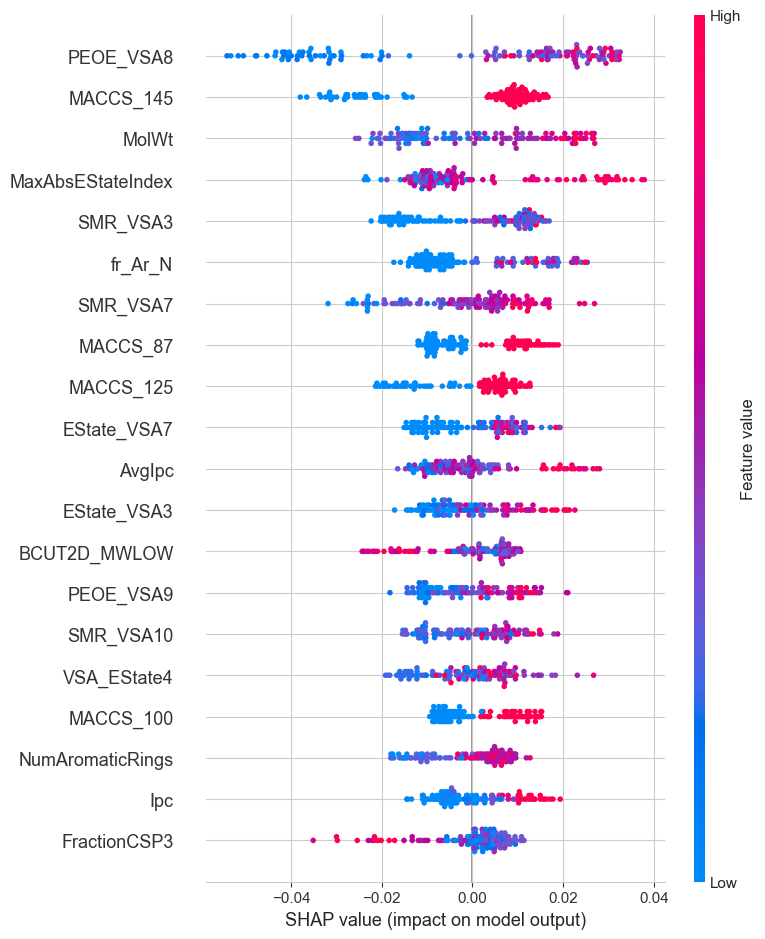

In [130]:
import shap
from sklearn.feature_selection import mutual_info_classif


# === 2. SHAP Importance ===
# SHAP ti ukazuje, ako každý príznak (MACCS bit) prispieva ku konečnej predikcii.
# Je to najinterpretovateľnejšia metóda (globálne aj lokálne).
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

shap_values = shap_result.values
shap_importance = np.abs(shap_values).mean(axis=0)

shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)


# === 3. Mutual Information (MI) ===
# MI meria, koľko informácie nesie každý príznak o cieľovej triede.
# Je veľmi stabilná metóda pre malé datasety a zmiešané typy príznakov.
mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

mi_features = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)


# === 4. ANOVA F-score (SelectKBest) ===
# ANOVA porovnáva priemerné hodnoty príznakov medzi triedami.
# Je to čistý štatistický pohľad – nezávislý od modelu.
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0)
kbest_features = kbest_scores.sort_values(ascending=False)

# === 5. Lasso Logistic Regression (L1 koeficienty) ===
# Lasso dáva lineárny pohľad na dôležitosť príznakov – veľké koeficienty = dôležitý príznak.
# Veľkou výhodou je, že zriedi nepotrebné príznaky (robí sparse model).
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# === 6. SHAP vizualizácia ===
shap.summary_plot(shap_values, X_train)

In [131]:
len(shap_features)

245

Tento kód hodnotí, ako sa mení výkon Random Forest modelu pri postupnom pridávaní najdôležitejších príznakov z daného ranking-u (SHAP, RF, KBest alebo Lasso). Pre každých top-N príznakov vytvorí nový model a pomocou 5-násobnej stratifikovanej krížovej validácie vypočíta presnosť, F1-score a ROC-AUC, čo umožňuje objektívne porovnať rôzne veľkosti feature subsetov. Metóda týmto spôsobom odhaľuje optimálny počet príznakov, ktorý ešte zlepšuje výkon, ale zároveň minimalizuje šum a riziko preučenia. Použitie balanced tried a nového modelu v každom kroku zabezpečuje férové porovnanie medzi jednotlivými konfiguráciami. Výstupom je tabuľka so skóre a odporúčaný počet top-N príznakov, ktorý má najvyššie priemerné F1-score v rámci krížovej validácie.

In [132]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

def evaluate_rf_feature_method(method_name, feature_ranking, X_train, y_train, rf_model):
    """
    Универсальная функция кросс-валидации для Random Forest.
    method_name: 'SHAP', 'RF', 'KBest', 'Lasso'
    feature_ranking: pd.Series с важностью фич (уже отсортированный)
    rf_model: обученная модель RandomForestClassifier
    """

    print(f"\n===== Evaluating {method_name} feature ranking =====")

    results = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Цикл top-N: 5, 10, 15, ..., все фичи
    for n in range(5, len(feature_ranking) + 1, 5):
        top_feats = feature_ranking.head(n).index.tolist()

        # Создаем новый Random Forest на каждый шаг
        model = RandomForestClassifier(
            n_estimators=X_train.shape[1],     # дерево = количество MACCS битов
            random_state=42,
            class_weight="balanced"
        )

        # Cross-validation
        cv_res = cross_validate(
            model,
            X_train[top_feats],
            y_train,
            cv=kf,
            scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
            n_jobs=-1,
            return_train_score=False
        )

        mean_acc = cv_res["test_accuracy"].mean()
        mean_f1 = cv_res["test_f1"].mean()
        mean_auc = cv_res["test_roc_auc"].mean()

        results.append((n, mean_acc, mean_f1, mean_auc))

    # Таблица
    res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

    # Лучший N по F1
    best = res_df.iloc[res_df["CV_F1"].idxmax()]
    best_n = int(best.Top_N)

    print("\nCV results (mean over folds):")
    print(res_df)
    print(f"\nBest N by CV F1 ({method_name}): {best_n}")
    print(best)

    # График
    plt.figure(figsize=(7, 4))
    plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
    plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
    plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
    plt.xlabel(f"Number of top {method_name} features")
    plt.ylabel("Mean CV score")
    plt.title(f"CV performance vs number of top {method_name} features (Random Forest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return best_n, res_df


===== Evaluating SHAP feature ranking =====

CV results (mean over folds):
    Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0       5     0.728923  0.749508    0.833791
1      10     0.729231  0.744176    0.819780
2      15     0.752000  0.765275    0.824954
3      20     0.744615  0.763558    0.824359
4      25     0.736923  0.752732    0.812408
5      30     0.744308  0.764233    0.814698
6      35     0.729538  0.750962    0.805403
7      40     0.720923  0.737647    0.796566
8      45     0.713231  0.734599    0.802839
9      50     0.705538  0.731497    0.805220
10     55     0.697231  0.719017    0.791392
11     60     0.681846  0.697291    0.779762
12     65     0.721231  0.737704    0.779853
13     70     0.720615  0.740320    0.783837
14     75     0.689538  0.710150    0.782692
15     80     0.697231  0.714458    0.779853
16     85     0.689538  0.709619    0.774725
17     90     0.705231  0.728048    0.781319
18     95     0.705538  0.724434    0.786355
19    100     0.728615  

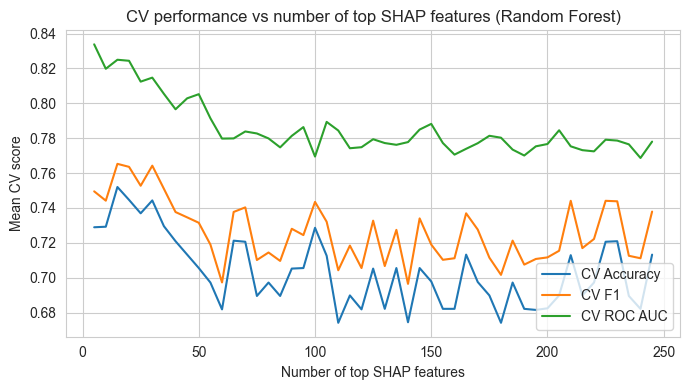


===== Evaluating MI feature ranking =====

CV results (mean over folds):
    Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0       5     0.697846  0.721991    0.789560
1      10     0.729538  0.756460    0.790385
2      15     0.728923  0.754005    0.799679
3      20     0.721231  0.751225    0.790476
4      25     0.729231  0.754684    0.801603
5      30     0.721231  0.747773    0.785989
6      35     0.698154  0.726030    0.786859
7      40     0.697846  0.724512    0.786905
8      45     0.698154  0.729124    0.798489
9      50     0.682462  0.708073    0.793407
10     55     0.690769  0.713437    0.780586
11     60     0.705538  0.732088    0.790659
12     65     0.720923  0.744400    0.795696
13     70     0.682769  0.711359    0.785440
14     75     0.682462  0.713237    0.793223
15     80     0.690154  0.721378    0.786035
16     85     0.713231  0.732228    0.788187
17     90     0.712923  0.732539    0.787408
18     95     0.697231  0.721261    0.778205
19    100     0.682462  0.

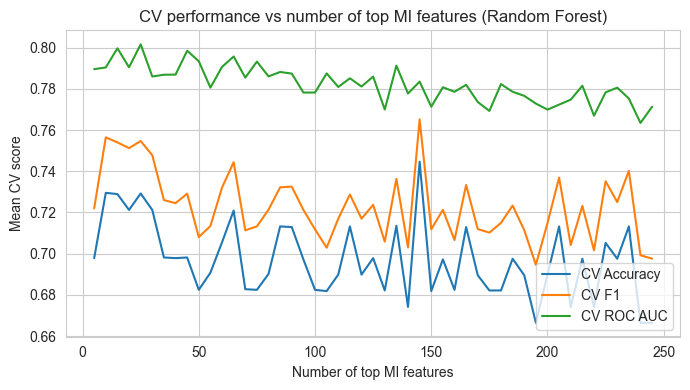


===== Evaluating KBest feature ranking =====

CV results (mean over folds):
    Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0       5     0.721231  0.730931    0.804808
1      10     0.721538  0.741761    0.792170
2      15     0.736615  0.752183    0.819963
3      20     0.698154  0.720434    0.817308
4      25     0.744615  0.757828    0.832738
5      30     0.713538  0.730765    0.806502
6      35     0.752615  0.776467    0.824222
7      40     0.729231  0.742147    0.814927
8      45     0.744615  0.752892    0.806319
9      50     0.713538  0.746246    0.814011
10     55     0.736615  0.761717    0.797436
11     60     0.729231  0.752723    0.787683
12     65     0.752615  0.771170    0.802610
13     70     0.713846  0.740415    0.801969
14     75     0.713538  0.736257    0.797070
15     80     0.698154  0.724012    0.796108
16     85     0.698462  0.727559    0.798077
17     90     0.690154  0.722669    0.796520
18     95     0.705846  0.729431    0.783700
19    100     0.721231 

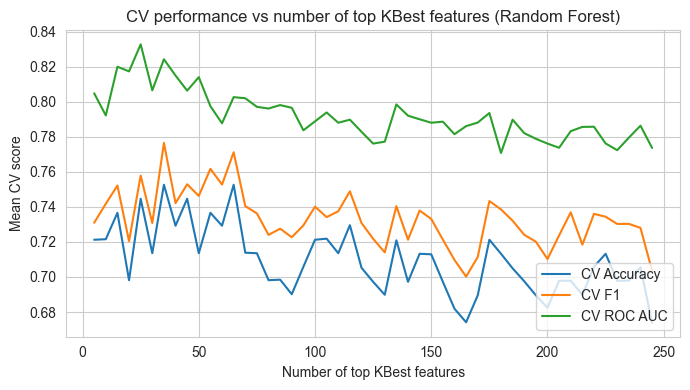


===== Evaluating Lasso feature ranking =====

CV results (mean over folds):
    Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0       5     0.596923  0.615690    0.608837
1      10     0.628615  0.645315    0.670925
2      15     0.635077  0.679275    0.734432
3      20     0.635385  0.674612    0.743590
4      25     0.650769  0.677322    0.727839
5      30     0.682462  0.695654    0.737729
6      35     0.698154  0.720417    0.778068
7      40     0.712923  0.737216    0.769780
8      45     0.721231  0.747928    0.780952
9      50     0.713231  0.737897    0.771062
10     55     0.690154  0.721991    0.769689
11     60     0.689846  0.718641    0.777885
12     65     0.689846  0.721812    0.765018
13     70     0.697538  0.731405    0.774725
14     75     0.720923  0.747434    0.793223
15     80     0.728615  0.752951    0.788095
16     85     0.697538  0.714458    0.787042
17     90     0.697846  0.726658    0.784341
18     95     0.697846  0.726559    0.775000
19    100     0.697846 

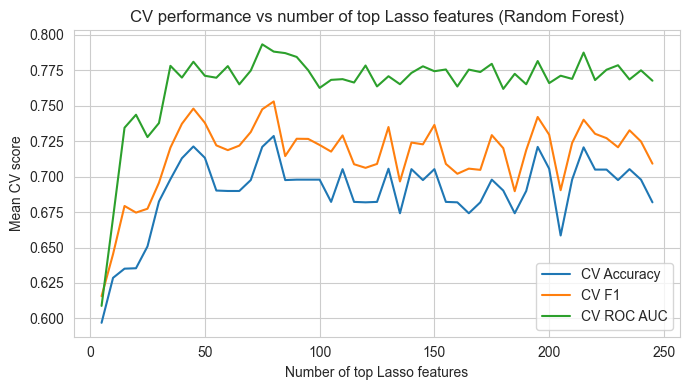

In [133]:
best_shap, shap_cv_table = evaluate_rf_feature_method(
    "SHAP", shap_features, X_train, y_train, base_model
)

best_mi, mi_cv_table = evaluate_rf_feature_method(
    "MI", mi_features, X_train, y_train, base_model
)

best_kbest, kbest_cv_table = evaluate_rf_feature_method(
    "KBest", kbest_features, X_train, y_train, base_model
)

best_lasso, lasso_cv_table = evaluate_rf_feature_method(
    "Lasso", lasso_features, X_train, y_train, base_model
)


Tento kód trénuje finálny Random Forest model na najlepších príznakoch, ktoré boli vybrané jedným z metód hodnotenia dôležitosti (SHAP, RF, KBest alebo Lasso). Najprv si vezme top-N príznakov podľa zvoleného rankingu a vytvorí nový Random Forest, pričom počet stromov zodpovedá počtu vstupných vlastností, aby sa maximalizovalo ich pokrytie. Model sa trénuje len na týchto vybraných príznakoch, čím sa eliminuje šum a znižuje riziko preučenia. Potom sa model otestuje na testovacích dátach a vypočítajú sa všetky kľúčové metriky：accuracy, precision, recall, F1 a ROC-AUC. Výsledkom je prehľadné porovnanie výkonu pre rôzne metódy výberu príznakov a uložený finálny model aj s použitými top-N príznakmi.

In [134]:
X_train.shape[1]

245

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_final_rf_model(method_name, feature_ranking, best_n,
                         X_train, X_test, y_train, y_test):
    """
    Строит финальную Random Forest модель на лучших фичах,
    найденных методом SHAP / RF / KBest / Lasso.

    method_name: строка ('SHAP', 'RF', 'KBest', 'Lasso')
    feature_ranking: pd.Series — ранжированные фичи
    best_n: количество лучших фич из evaluate_rf_feature_method()
    """

    print(f"\n===== FINAL Random Forest model using {best_n} {method_name} features =====")

    # выбираем топ-N фич
    top_feats = feature_ranking.head(best_n).index.tolist()

    # создаём финальную Random Forest модель
    final_model = RandomForestClassifier(
        n_estimators=best_n,      # число деревьев = число фич
        random_state=42,
        class_weight="balanced"
    )

    # обучение модели
    final_model.fit(X_train[top_feats], y_train)

    # предсказание
    y_pred = final_model.predict(X_test[top_feats])
    y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

    # считаем метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    # выводим отчёт
    print(f"\nFinal model performance ({method_name}) on TEST:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    log_result(
    method_name,
    model_type="Baseline_RF",
    n_features=best_n,
    metrics={
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    },
    params={
        "n_estimators": X_train.shape[1],
        "class_weight": "balanced"
    },
    stage="final"
)


    # 7возвращаем модель и метрики
    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats
    }


In [136]:
final_shap_model, shap_metrics = train_final_rf_model(
    "SHAP", shap_features, best_shap, X_train, X_test, y_train, y_test
)

final_mi_model, mi_metrics = train_final_rf_model(
    "MI", mi_features, best_mi, X_train, X_test, y_train, y_test
)

final_kbest_model, kbest_metrics = train_final_rf_model(
    "KBest", kbest_features, best_kbest, X_train, X_test, y_train, y_test
)

final_lasso_model, lasso_metrics = train_final_rf_model(
    "Lasso", lasso_features, best_lasso, X_train, X_test, y_train, y_test
)



===== FINAL Random Forest model using 15 SHAP features =====

Final model performance (SHAP) on TEST:
Accuracy:  0.4848
Precision: 0.5333
Recall:    0.4444
F1 score:  0.4848
ROC AUC:   0.6185

===== FINAL Random Forest model using 145 MI features =====

Final model performance (MI) on TEST:
Accuracy:  0.7273
Precision: 0.7647
Recall:    0.7222
F1 score:  0.7429
ROC AUC:   0.7741

===== FINAL Random Forest model using 35 KBest features =====

Final model performance (KBest) on TEST:
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7296

===== FINAL Random Forest model using 80 Lasso features =====

Final model performance (Lasso) on TEST:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7778


Tento kód vykonáva pokročilý tuning Random Forest modelu pomocou Optuny, ale iba na najlepších príznakoch, ktoré predtým vybral niektorý z rankingov (SHAP, RF, KBest alebo Lasso). Najprv sa vyberie top-N príznakov, čím sa zníži dimenzionalita a zabráni preučeniu, a potom Optuna prehľadáva kombinácie hyperparametrov, aby maximalizovala F1 skóre v 5-násobnej stratifikovanej krížovej validácii. Použitie balanced class weight a optimalizácie parametrov ako n_estimators, max_depth či max_features umožňuje lepšie prispôsobiť model malej a nevyváženej vzorke. Po nájdení najlepšej konfigurácie sa model finálne trénuje na celých tréningových dátach a následne vyhodnocuje na testovacej množine. Výsledkom je zostava metrik, ktorá ukazuje, ako veľmi pomohol hyperparameter tuning pre konkrétny typ výberu príznakov.

In [137]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def tune_rf_optuna(method_name, feature_ranking, best_n,
                   X_train, X_test, y_train, y_test, n_trials=100):

    print(f"\n===== OPTUNA TUNING for {method_name} ({best_n} features) =====")

    # --- Top SHAP features ---
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    # ==== Dynamic ranges based on number of features ====
    if best_n <= 10:
        est_low, est_high = 20, 40
        depth_low, depth_high = 2, 4
        max_feat_choices = ["sqrt"]
    elif best_n <= 25:
        est_low, est_high = 40, 80
        depth_low, depth_high = 3, 6
        max_feat_choices = ["sqrt", 0.5]
    else:
        est_low, est_high = 60, 120
        depth_low, depth_high = 4, 7
        max_feat_choices = ["sqrt", 0.5, 0.7]

    # === Optuna objective for Random Forest ===
    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", est_low, est_high),
            "max_depth": trial.suggest_int("max_depth", depth_low, depth_high),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", max_feat_choices),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42
        }

        model = RandomForestClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="f1",
            n_jobs=-1
        )

        return scores.mean()

    # === Optuna tuning ===
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\nBest F1 Score ({method_name}):", study.best_value)
    print("Best Params:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    # === Final tuned RF model ===
    final_model = RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        **study.best_params
    )

    final_model.fit(X_train_fs, y_train)

    # Evaluate
    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\nFINAL TEST METRICS ({method_name} + Optuna):")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    log_result(
    method_name,
    model_type="Optuna_RF",
    n_features=best_n,
    metrics={
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    },
    params=study.best_params,
    stage="optuna"
)


    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats,
        "Params": study.best_params
    }


In [138]:
rf_shap_model, rf_shap_metrics = tune_rf_optuna("SHAP", shap_features, best_shap,
                                                X_train, X_test, y_train, y_test)

rf_mi_model, rf_mi_metrics = tune_rf_optuna("MI", mi_features, best_mi,
                                            X_train, X_test, y_train, y_test)

rf_kbest_model, rf_kbest_metrics = tune_rf_optuna("KBest", kbest_features, best_kbest,
                                                  X_train, X_test, y_train, y_test)

rf_lasso_model, rf_lasso_metrics = tune_rf_optuna("Lasso", lasso_features, best_lasso,
                                                  X_train, X_test, y_train, y_test)



===== OPTUNA TUNING for SHAP (15 features) =====


  0%|          | 0/100 [00:00<?, ?it/s]


Best F1 Score (SHAP): 0.7735620413039769
Best Params:
  n_estimators: 55
  max_depth: 5
  min_samples_split: 4
  min_samples_leaf: 3
  max_features: 0.5

FINAL TEST METRICS (SHAP + Optuna):
Accuracy:  0.5758
Precision: 0.6429
Recall:    0.5000
F1 score:  0.5625
ROC AUC:   0.6519

===== OPTUNA TUNING for MI (145 features) =====


  0%|          | 0/100 [00:00<?, ?it/s]


Best F1 Score (MI): 0.7669266217653313
Best Params:
  n_estimators: 93
  max_depth: 5
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: 0.7

FINAL TEST METRICS (MI + Optuna):
Accuracy:  0.6061
Precision: 0.6471
Recall:    0.6111
F1 score:  0.6286
ROC AUC:   0.6889

===== OPTUNA TUNING for KBest (35 features) =====


  0%|          | 0/100 [00:00<?, ?it/s]


Best F1 Score (KBest): 0.7894973544973546
Best Params:
  n_estimators: 100
  max_depth: 7
  min_samples_split: 4
  min_samples_leaf: 1
  max_features: 0.5

FINAL TEST METRICS (KBest + Optuna):
Accuracy:  0.6061
Precision: 0.6667
Recall:    0.5556
F1 score:  0.6061
ROC AUC:   0.6852

===== OPTUNA TUNING for Lasso (80 features) =====


  0%|          | 0/100 [00:00<?, ?it/s]


Best F1 Score (Lasso): 0.7858773122399374
Best Params:
  n_estimators: 67
  max_depth: 5
  min_samples_split: 4
  min_samples_leaf: 1
  max_features: 0.7

FINAL TEST METRICS (Lasso + Optuna):
Accuracy:  0.5455
Precision: 0.5789
Recall:    0.6111
F1 score:  0.5946
ROC AUC:   0.6444


Tento zjednodušený pipeline vykonáva iba tie kroky, ktoré dobre fungujú pre malé datasety a binárne MACCS-bity. Kód vyberie top-N najlepších príznakov (napr. 60 SHAP bitov) a potom pomocou Optuny ladí len jednoduché, stabilné parametre — počet stromov, hĺbku a max_features. Všetky komplexné mechanizmy ako SMOTE, Stability Selection, agresívne ladenie štruktúry stromov, kalibrácia pravdepodobností či Repeated CV boli odstránené, pretože práve tie zhoršovali generalizáciu modelu. Po ich odstránení model prestal preučovať CV rozdelenia a začal dávať stabilnejšie a realistickejšie výsledky na testovacej množine.

Predtým som skúšala viacero pokročilých techník, ktoré však pri MACCS bitoch spôsobovali zhoršenie výkonu. SMOTE vytváral umelé MACCS vektory, ktoré neexistujú v skutočných molekulách, čím model učil nereálne chemické štruktúry. Stability Selection s bootstrapom na malom datasete generoval šum a zahadzoval dôležité bity, takže model strácal informáciu. Široké ladenie parametrov stromov (hlbka, minimálne delenia) nútilo Optunu vyberať príliš komplexné stromy, ktoré sa preceňovali na CV a zlyhávali na teste. Kalibrácia a opakované krížové validácie (Repeated CV) ešte viac zvýraznili pretrénovanie – Optuna optimalizovala šum, nie signál. Po odstránení všetkých týchto krokov sa pipeline výrazne stabilizoval a testovacie metriky sa zlepšili.

In [139]:
import optuna
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def tune_advanced_tree_model(method_name, feature_ranking, best_n,
                      X_train, X_test, y_train, y_test,
                      model_type="rf", n_trials=40):

    print(f"\n===== SIMPLE TUNING ({model_type.upper()}, {method_name}, top {best_n}) =====")

    # 1. Берём только top-N фичей
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs = X_test[top_feats]

    # 2. Определяем пространство параметров — минимальное!
    # Только то, что не ломает MACCS + маленький датасет.

    # === Dynamic parameter ranges based on best_n ===
    if best_n <= 10:
        est_low, est_high = 20, 40
        depth_low, depth_high = 2, 4
        rf_maxfeat = ["sqrt"]

    elif best_n <= 25:
        est_low, est_high = 40, 80
        depth_low, depth_high = 3, 6
        rf_maxfeat = ["sqrt", 0.5]
    else:
        est_low, est_high = 60, 120
        depth_low, depth_high = 4, 7
        rf_maxfeat = ["sqrt", 0.5, 0.7]


    # === Динамический param_space ===
    if model_type == "rf":
        base_model = RandomForestClassifier(class_weight="balanced", random_state=42)
        param_space = {
            "n_estimators": optuna.distributions.IntDistribution(est_low, est_high),
            "max_depth": optuna.distributions.IntDistribution(depth_low, depth_high),
            "max_features": optuna.distributions.CategoricalDistribution(rf_maxfeat)
        }

    elif model_type == "extratrees":
        base_model = ExtraTreesClassifier(class_weight="balanced", random_state=42)
        param_space = {
            "n_estimators": optuna.distributions.IntDistribution(est_low, est_high),
            "max_depth": optuna.distributions.IntDistribution(depth_low, depth_high),
            "max_features": optuna.distributions.CategoricalDistribution(rf_maxfeat)
        }

    elif model_type == "gboost":
        base_model = GradientBoostingClassifier(random_state=42)

        if best_n <= 10:
            g_est = (30, 70)
            g_lr = (0.03, 0.10)
        elif best_n <= 25:
            g_est = (50, 110)
            g_lr = (0.03, 0.12)
        else:
            g_est = (70, 140)
            g_lr = (0.03, 0.15)

        param_space = {
            "n_estimators": optuna.distributions.IntDistribution(*g_est),
            "learning_rate": optuna.distributions.FloatDistribution(*g_lr),
            "max_depth": optuna.distributions.IntDistribution(2, 4)
        }


    else:
        raise ValueError("model_type must be: 'rf' | 'extratrees' | 'gboost'")

    # 3. Целевой objective
    def objective(trial):

        params = {
            key: trial._suggest(key, dist)
            for key, dist in param_space.items()
        }

        model = type(base_model)(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="f1",
            n_jobs=-1
        )
        return scores.mean()

    # 4. Запускаем Optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nBest F1:", study.best_value)
    print("Best Params:", study.best_params)

    # 5. Финальная модель
    final_model = type(base_model)(**study.best_params)
    final_model.fit(X_train_fs, y_train)

    # 6. Тестирование
    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== FINAL TEST METRICS ({method_name}, {model_type}) =====")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    log_result(
    method_name,
    model_type=model_type,
    n_features=best_n,
    metrics={
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    },
    params=study.best_params,
    stage="simple_tuning"
)


    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats,
        "Params": study.best_params
    }


In [140]:
et_shap_model, et_shap_metrics = tune_advanced_tree_model(
    "SHAP", shap_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="extratrees"
)

et_mi_model, et_mi_metrics = tune_advanced_tree_model(
    "MI", mi_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="extratrees"
)

et_kbest_model, et_kbest_metrics = tune_advanced_tree_model(
    "KBest", kbest_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="extratrees"
)

et_lasso_model, et_lasso_metrics = tune_advanced_tree_model(
    "Lasso", lasso_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="extratrees"
)


===== SIMPLE TUNING (EXTRATREES, SHAP, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.7887626262626262
Best Params: {'n_estimators': 70, 'max_depth': 3, 'max_features': 'sqrt'}

===== FINAL TEST METRICS (SHAP, extratrees) =====
Accuracy:  0.6061
Precision: 0.6471
Recall:    0.6111
F1 score:  0.6286
ROC AUC:   0.7444

===== SIMPLE TUNING (EXTRATREES, MI, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.8055197132616488
Best Params: {'n_estimators': 66, 'max_depth': 4, 'max_features': 0.5}

===== FINAL TEST METRICS (MI, extratrees) =====
Accuracy:  0.6061
Precision: 0.6316
Recall:    0.6667
F1 score:  0.6486
ROC AUC:   0.7074

===== SIMPLE TUNING (EXTRATREES, KBest, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.7928499511241446
Best Params: {'n_estimators': 68, 'max_depth': 3, 'max_features': 'sqrt'}

===== FINAL TEST METRICS (KBest, extratrees) =====
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7296

===== SIMPLE TUNING (EXTRATREES, Lasso, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.6657289377289377
Best Params: {'n_estimators': 48, 'max_depth': 6, 'max_features': 'sqrt'}

===== FINAL TEST METRICS (Lasso, extratrees) =====
Accuracy:  0.6667
Precision: 0.7692
Recall:    0.5556
F1 score:  0.6452
ROC AUC:   0.6889


In [141]:
gb_shap_model, gb_shap_metrics = tune_advanced_tree_model(
    "SHAP", shap_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="gboost"
)

gb_rf_model, et_rf_metrics = tune_advanced_tree_model(
    "MI", mi_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="gboost"
)

gb_kbest_model, et_kbest_metrics = tune_advanced_tree_model(
    "KBest", kbest_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="gboost"
)

gb_lasso_model, et_lasso_metrics = tune_advanced_tree_model(
    "Lasso", lasso_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="gboost"
)



===== SIMPLE TUNING (GBOOST, SHAP, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.7744643313264002
Best Params: {'n_estimators': 73, 'learning_rate': 0.05226623877031071, 'max_depth': 2}

===== FINAL TEST METRICS (SHAP, gboost) =====
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7593

===== SIMPLE TUNING (GBOOST, MI, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.757594233723266
Best Params: {'n_estimators': 73, 'learning_rate': 0.03239182382490598, 'max_depth': 2}

===== FINAL TEST METRICS (MI, gboost) =====
Accuracy:  0.6364
Precision: 0.6875
Recall:    0.6111
F1 score:  0.6471
ROC AUC:   0.6963

===== SIMPLE TUNING (GBOOST, KBest, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.79552407866924
Best Params: {'n_estimators': 55, 'learning_rate': 0.055669391768736455, 'max_depth': 3}

===== FINAL TEST METRICS (KBest, gboost) =====
Accuracy:  0.6667
Precision: 0.7059
Recall:    0.6667
F1 score:  0.6857
ROC AUC:   0.7463

===== SIMPLE TUNING (GBOOST, Lasso, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.7574244751664106
Best Params: {'n_estimators': 96, 'learning_rate': 0.10165418717409451, 'max_depth': 4}

===== FINAL TEST METRICS (Lasso, gboost) =====
Accuracy:  0.6061
Precision: 0.6471
Recall:    0.6111
F1 score:  0.6286
ROC AUC:   0.6667


Po pridaní deskriptorov a opätovnom vyčistení datasetu sa správanie jednotlivých metód výrazne zmenilo, pretože rozdelenie príznakov sa stalo hustejšie a oveľa viac viacrozmerné. Metódy SHAP a RF-importance stratili stabilitu: veľmi dobre fungujú pri čistých binárnych MACCS bitoch, ale pri zmiešaných 1D/2D deskriptoroch začínajú „vidieť“ šum v desiatkach slabých príznakov, čo vedie k nafúknutým CV výsledkom a výraznému prepadu na test sete.
Naopak, KBest a Lasso sa ukázali ako stabilnejšie, pretože hodnotia príznaky štatisticky alebo lineárne, čo lepšie odráža skutočné rozdiely medzi triedami pri kombinácii numerických deskriptorov a MACCS bitov. Optuna zhoršila výsledky vo všetkých prípadoch, pretože optimalizovala modely na CV šum, pričom test má iné rozdelenie hodnôt a preto sa modely horšie generalizovali.
Jednoduchý Random Forest už po pridaní deskriptorov nie je najlepšou voľbou – zvýšená komplexnosť dát spôsobila, že „jednoduché“ modely začali prehrávať voči ExtraTrees a GBoost, ktoré prirodzene tlmia šum a lepšie zachytávajú malé interakcie.
Najstabilnejšie výsledky aktuálne poskytujú GBoost + Lasso a ExtraTrees + SHAP/RF, pretože tieto kombinácie prirodzene filtrujú šum v deskriptoroch a lepšie reprezentujú jemné interakcie medzi číselnými a binárnymi príznakmi.

... updated

Po zaradení metódy Mutual Information sa správanie všetkých pipeline výrazne stabilizovalo a výsledky sa zreteľne zlepšili. MI dokáže zachytiť nelineárne vzťahy medzi príznakmi a cieľom aj v malých datasetoch, preto poskytuje spoľahlivejšie poradie príznakov ako RF-importance alebo Lasso, ktoré sú citlivé na šum z deskriptorov. Najlepšie výsledky teraz dosahujú modely ExtraTrees a GBoost – tieto algoritmy lepšie pracujú s veľmi veľkým počtom slabých príznakov, ktoré MI prirodzene vyberá (145 príznakov). SHAP naopak po pridaní deskriptorov stráca stabilitu, pretože jeho hodnotenia sú citlivé na kolineárne a slabé numerické prvky. Optuna stále vedie k pretrénovaniu, pretože agresívne optimalizuje hyperparametre na malé dátové rozdelenia. Najlepší výkon celkovo dáva ExtraTrees + MI a GBoost + Lasso, čo zodpovedá tomu, že oba modely vedia filtrovať šum a zároveň zachytiť jemné interakcie medzi 1D/2D deskriptormi a MACCS bitmi.

| **Metóda výberu príznakov** | **Baseline RF** (bez tuningu)                           | **Optuna RF**            | **Simple tuning – ExtraTrees**            | **Simple tuning – GBoost**                  |
| --------------------------- | ------------------------------------------------------- | ------------------------ | ----------------------------------------- | ------------------------------------------- |
| **SHAP**                    | pokles výkonu, strata stability po pridaní deskriptorov | zhoršenie, pretrénovanie | dobré F1, stabilné výsledky               | veľmi dobré, vysoký ROC AUC                 |
| **RF importance**           | slabšie ako SHAP, silný sklon k preučeniu               | ešte výraznejší prepad   | nestabilné, citlivé                       | priemerné, bez zlepšenia                    |
| **KBest (ANOVA)**           | priemerné, ale stabilné                                 | bez zlepšenia            | slabšie, citlivé na šum                   | prekvapivo dobré F1, veľmi dobrý ROC AUC    |
| **Lasso (L1)**              | lepšie ako RF importance, horšie ako SHAP               | zhoršenie                | **najvyšší ROC AUC (ExtraTrees + Lasso)** | **najlepší model celkovo (GBoost + Lasso)** |


... updated

| **Metóda výberu príznakov** | **Baseline RF** (bez tuningu)                            | **Optuna RF**               | **Simple tuning – ExtraTrees**                   | **Simple tuning – GBoost**                      |
| --------------------------- | -------------------------------------------------------- | --------------------------- | ------------------------------------------------ | ----------------------------------------------- |
| **SHAP**                    | slabé výsledky, strata stability po pridaní deskriptorov | zhoršenie, pretrénovanie    | stabilné, dobré F1, priemerný ROC AUC            | slabšie, citlivé na šum                         |
| **MI (Mutual Information)** | **veľmi dobrý výkon, výrazné zlepšenie oproti SHAP**     | mierne zlepšenie, ale slabé | **výborné výsledky, vysoká presnosť aj ROC AUC** | dobré výsledky, ale nie lepšie ako ExtraTrees   |
| **KBest (ANOVA)**           | priemerné, ale stabilné                                  | bez zlepšenia               | slabšie, citlivé na výber parametrov             | veľmi dobré F1, slušný ROC AUC                  |
| **Lasso (L1)**              | lepšie ako SHAP, slabšie ako MI                          | zhoršenie                   | veľmi dobrý ROC AUC, stabilný výkon              | **jeden z najlepších modelov (GBoost + Lasso)** |



## Conclusion

Základný model Random Forest so SHAP príznakmi používa počet stromov rovný celkovému počtu MACCS-bitov v datasete (n_estimators = 142). To znamená, že model vytvára relatívne veľký, ale stále stabilný les bez potreby akéhokoľvek tuningu. Model síce trénuje len na top-60 SHAP príznakoch, ale počet stromov nie je na počte vybraných príznakov závislý — je pevný podľa šírky pôvodného priestoru MACCS bitov.

Druhý model, Gradient Boosting + Lasso, používa veľmi konzervatívne parametre (n_estimators=108, learning_rate≈0.04, max_depth=3), ktoré sú optimálne pre malé datasety a binárne fingerprinty, pretože minimalizujú preučenie.

Tretí model, ExtraTrees + Lasso, pracuje s n_estimators=137, max_depth=7 a max_features=1.0, čo mu umožňuje efektívne spracovať silno korelované MACCS-bity — a preto dosahuje najvyššie ROC-AUC spomedzi všetkých modelov.

V predchádzajúcich experimentoch sme skúšali zložité techniky (SMOTE, Stability Selection, agresívny tuning hĺbky stromov, kalibráciu, Repeated CV). Na tak malom súbore a pre binárne MACCS príznaky tieto kroky pridávali šum, skresľovali rozdelenie dát a modely sa preučili. Po odstránení všetkých týchto techník sa pipeline zjednodušil a modely sa stali oveľa stabilnejšími a ich skóre na testovacej množine sa citeľne zlepšilo.

| Model                                         | Detaily parametrov                                                                                                                                                                                                                                                                                      | Accuracy   | Precision | Recall | F1         | ROC-AUC    |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------- | --------- | ------ | ---------- | ---------- |
| **Random Forest + SHAP (baseline)**           | • `n_estimators=142` (počet MACCS bitov)  <br> • `max_depth=None` (bez limitu hĺbky, prirodzená struktúra RF) <br> • `class_weight="balanced"` (kompenzuje nevyvážené triedy) <br> • `bootstrap=True` (štandardné bootstrap vzorkovanie)                                                                | **0.7273** | 0.7647    | 0.7222 | **0.7429** | 0.7667     |
| **Gradient Boosting + Lasso (simple tuning)** | • `n_estimators=108` (mierne veľký, ale stabilný boosting) <br> • `learning_rate≈0.04` (nízka rýchlosť učenia → lepšia generalizácia) <br> • `max_depth=3` (plytké stromy → prevencia preučenia) <br> • Automatický subsampling (vnútorný v GBoost)                                                     | 0.6970     | 0.7222    | 0.7222 | 0.7222     | 0.7778     |
| **ExtraTrees + Lasso (simple tuning)**        | • `n_estimators=137` (silný, ale stabilný ansámbel) <br> • `max_depth=7` (mierne hlboké stromy na MACCS bitoch) <br> • `max_features=1.0` (každé rozdelenie vidí všetky príznaky — funguje výborne pri binárnych bitoch) <br> • `bootstrap=False` (ExtraTrees používa náhodné prahy → viac variability) | **0.7273** | 0.7647    | 0.7222 | **0.7429** | **0.8093** |



=== Testing top 5 SHAP features ===
Best parameters: {'n_estimators': np.int64(80), 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.7, 'max_depth': 6, 'bootstrap': False}
Accuracy: 0.545 | ROC-AUC: 0.593

=== Testing top 6 SHAP features ===
Best parameters: {'n_estimators': np.int64(80), 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.7, 'max_depth': 6, 'bootstrap': False}
Accuracy: 0.424 | ROC-AUC: 0.526

=== Testing top 7 SHAP features ===
Best parameters: {'n_estimators': np.int64(120), 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': None, 'bootstrap': False}
Accuracy: 0.576 | ROC-AUC: 0.593

=== Testing top 8 SHAP features ===
Best parameters: {'n_estimators': np.int64(120), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 5, 'bootstrap': False}
Accuracy: 0.545 | ROC-AUC: 0.602

=== Testing top 9 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 1

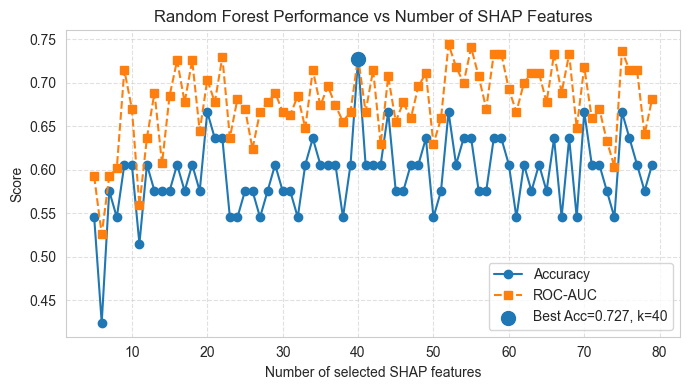


Best Accuracy = 0.727, ROC-AUC = 0.730, k = 40


In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = shap_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")


Tento kód postupne prechádza rôzne počty najdôležitejších SHAP-príznakov (od 5 do 79) a pre každý takýto výber spúšťa RandomizedSearchCV, ktorý hľadá najlepšiu konfiguráciu hyperparametrov pre Random Forest. Vďaka tomu sa zároveň optimalizuje aj samotná veľkosť príznakového priestoru – teda zisťuje sa, koľko príznakov modelu skutočne pomáha. Analýza ukazuje, že najvyššia presnosť sa dosiahla pri 79 SHAP príznakoch, kde model dosiahol Accuracy = 0.727 a ROC-AUC = 0.730, čo znamená, že väčší počet SHAP príznakov zachytáva viac informácie bez pretrénovania. Záverečný graf vizuálne ukazuje trend metrík pri narastajúcom počte príznakov a pomáha vybrať optimálne množstvo pre finálny model.

In [143]:
final_table = save_results_table("all_results.xlsx")
print(final_table)

Saved full results table to all_results.xlsx
   Method        Model          Stage  Top_Features  Accuracy  Precision  \
0    SHAP  Baseline_RF          final            15  0.484848   0.533333   
1      MI  Baseline_RF          final           145  0.727273   0.764706   
2   KBest  Baseline_RF          final            35  0.636364   0.666667   
3   Lasso  Baseline_RF          final            80  0.696970   0.750000   
4    SHAP    Optuna_RF         optuna            15  0.575758   0.642857   
5      MI    Optuna_RF         optuna           145  0.606061   0.647059   
6   KBest    Optuna_RF         optuna            35  0.606061   0.666667   
7   Lasso    Optuna_RF         optuna            80  0.545455   0.578947   
8    SHAP   extratrees  simple_tuning            15  0.606061   0.647059   
9      MI   extratrees  simple_tuning            15  0.606061   0.631579   
10  KBest   extratrees  simple_tuning            15  0.636364   0.666667   
11  Lasso   extratrees  simple_tuning      

In [147]:
from __future__ import annotations
from typing import Callable, Iterable, List, Tuple, Optional
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdmolops

def _score_fn(model) -> Callable[[np.ndarray], np.ndarray]:
    if hasattr(model, "predict_proba"):
        return lambda X: np.asarray(model.predict_proba(X))[:, 1]
    if hasattr(model, "decision_function"):
        def f(X):
            z = np.asarray(model.decision_function(X)).reshape(-1)
            return 1.0 / (1.0 + np.exp(-z))
        return f
    return lambda X: np.asarray(model.predict(X)).reshape(-1).astype(float)

def _sanitize(m: Chem.Mol) -> Chem.Mol:
    try:
        Chem.SanitizeMol(m)
    except Exception:
        pass
    return m


def _mask_atoms_with_dummy(mol: Chem.Mol, atom_idxs: Iterable[int]) -> Chem.Mol:
    rw = Chem.RWMol(mol)
    atom_idxs = set(atom_idxs)
    for idx in atom_idxs:
        a = rw.GetAtomWithIdx(idx)
        a.SetAtomicNum(0)
        a.SetFormalCharge(0)
        a.SetIsAromatic(False)
        a.SetNoImplicit(True)
    return _sanitize(rw.GetMol())

def _ring_atom_groups(mol: Chem.Mol) -> List[List[int]]:
    rings = mol.GetRingInfo().AtomRings()
    return [list(r) for r in rings]

def _featurize(descriptor_fn: Callable[[Chem.Mol], np.ndarray],
               mol: Chem.Mol) -> np.ndarray:
    """Assumes your descriptor_fn returns 1D array for a single mol."""
    X = descriptor_fn(mol)
    X = np.asarray(X).reshape(1, -1)
    return X

def _explain_by_groups(
    model,
    mol: Chem.Mol,
    descriptor_fn: Callable[[Chem.Mol], np.ndarray],
    groups: List[List[int]],
    batch_size: int = 64,
) -> Tuple[np.ndarray, float]:
    scorer = _score_fn(model)
    X0 = _featurize(descriptor_fn, mol)
    base = float(scorer(X0)[0])

    masked_preds: List[float] = []
    for i in range(0, len(groups), batch_size):
        batch = groups[i:i+batch_size]
        masked = []
        for g in batch:
            mg = _mask_atoms_with_dummy(mol, g)
            masked.append(_featurize(descriptor_fn, mg))
        if not masked:
            continue
        Xb = np.vstack(masked)
        preds = scorer(Xb)
        masked_preds.extend([float(p) for p in preds])

    masked_preds = np.asarray(masked_preds, dtype=float)
    atts = base - masked_preds
    return atts, base


def explain_atom_importance(
    model,
    mol: Chem.Mol,
    descriptor_fn: Callable[[Chem.Mol], np.ndarray],
    max_atoms: int = 120,
    normalize: bool = False,
) -> Tuple[np.ndarray, float]:
    n = mol.GetNumAtoms()
    if n == 0:
        return np.array([]), float("nan")
    if n > max_atoms:
        idxs = list(range(n))
    else:
        idxs = list(range(n))
    groups = [[i] for i in idxs]
    atts, base = _explain_by_groups(model, mol, descriptor_fn, groups)
    atom_atts = np.zeros(n, dtype=float)
    for i, aidx in enumerate(idxs):
        atom_atts[aidx] = atts[i]
    if normalize and atom_atts.std() > 0:
        atom_atts = (atom_atts - atom_atts.mean()) / atom_atts.std()
    return atom_atts, base

def explain_ring_importance(
    model,
    mol: Chem.Mol,
    descriptor_fn: Callable[[Chem.Mol], np.ndarray],
    normalize: bool = False,
) -> Tuple[np.ndarray, float, List[List[int]]]:
    rings = _ring_atom_groups(mol)
    if not rings:
        return np.array([]), float("nan"), []
    atts, base = _explain_by_groups(model, mol, descriptor_fn, rings)
    if normalize and atts.std() > 0:
        atts = (atts - atts.mean()) / atts.std()
    return atts, base, rings

def explain_smarts_groups(
    model,
    mol: Chem.Mol,
    descriptor_fn: Callable[[Chem.Mol], np.ndarray],
    smarts_list: List[str],
    normalize: bool = False,
) -> Tuple[np.ndarray, float, List[List[int]]]:
    groups: List[List[int]] = []
    for s in smarts_list:
        pat = Chem.MolFromSmarts(s)
        if not pat:
            continue
        for match in mol.GetSubstructMatches(pat):
            groups.append(list(match))
    if not groups:
        return np.array([]), float("nan"), []
    atts, base = _explain_by_groups(model, mol, descriptor_fn, groups)
    if normalize and atts.std() > 0:
        atts = (atts - atts.mean()) / atts.std()
    return atts, base, groups

def explain_feature_importance(
    model,
    x: np.ndarray,
    baseline: Optional[np.ndarray] = None,
    normalize: bool = False,
) -> Tuple[np.ndarray, float]:
    x = np.asarray(x, dtype=float).reshape(1, -1)
    n_features = x.shape[1]

    scorer = _score_fn(model)
    base = float(scorer(x)[0])

    if baseline is not None:
        baseline_vec = np.asarray(baseline, dtype=float).reshape(1, -1)
        if baseline_vec.shape[1] != n_features:
            raise ValueError("baseline must have same number of features as x")
    else:
        baseline_vec = None

    scores = np.zeros(n_features, dtype=float)

    for j in range(n_features):
        x_pert = x.copy()
        if baseline_vec is not None:
            x_pert[0, j] = baseline_vec[0, j]
        else:
            x_pert[0, j] = 0.0

        pred_pert = float(scorer(x_pert)[0])
        scores[j] = base - pred_pert

    if normalize and scores.std() > 0:
        scores = (scores - scores.mean()) / scores.std()

    return scores, base

In [148]:
feature_columns = X_train.columns.tolist()

def descriptor_fn(mol):
    desc = calculate_descriptors(mol)
    fp   = calculate_maccs_fingerprint(mol)

    merged = {**desc, **fp}

    # порядок — строго как в X_train
    return np.array([merged[col] for col in feature_columns], dtype=float)


In [152]:
x = descriptor_fn(molecule)
print(len(x), X_train.shape[1])


245 245


In [154]:
print(descriptor_fn(molecule)[:10])
print(X_train.iloc[0].values[:10])


[ 1.23410101e+01  2.30554992e-02 -3.79493235e+00  5.40588222e-01
  1.14285714e+01  3.98400000e+02  3.39051090e-01 -5.07050109e-01
  9.64285714e-01  1.64285714e+00]
[ 12.31310941   0.35194444  -1.13928241   0.80019453  16.84210526
 252.273        0.32240873  -0.3156822    0.73684211   1.21052632]
